In [21]:
import numpy as np
from src.cyc_gbm import CycGBM, CycGLM
from src.cyc_gbm.utils import tune_kappa, train_test_split
from src.cyc_gbm.distributions import initiate_distribution
from matplotlib import pyplot as plt
import pandas as pd

In [22]:
# Simulation parameters
n = 100000
p = 9
dist = "gamma"
simulation_seed = 10
cv_seed = 11


def parameter_function(X):
    z0 = -1 + 0.5*X[:,1] - 0.25*X[:,2]**2 + 0.5*np.abs(X[:,3])*np.sin(2*X[:,3]) * 0.25*X[:,4]*X[:,5] +0.125*X[:,5]**2*X[:,6]
    z1 = 2 + 0.3*X[:,2]+0.02*np.abs(X[:,1])
    return np.stack([z0, z1])


# GBM hyperparameters
kappa_max = 100
eps_gbm = 0.1
max_depth = 3
min_samples_leaf = 5
n_splits = 2

# GLM hyperparameters
max_iter = 1000
eps_glm = 1e-5
tol = 0.001

## Simulate data

In [23]:
rng = np.random.default_rng(seed=simulation_seed)
X = np.concatenate([np.ones((1, n)), rng.normal(0, 1, (p - 1, n))]).T

distribution = initiate_distribution(dist=dist)
z = parameter_function(X)
y = distribution.simulate(z=z, rng=rng)
X_train, X_test, y_train, y_test, z_train, z_test,_,_ = train_test_split(
    X=X, y=y, z=z, test_size=0.2, rng=rng
)
z_hat = {
    data_set: {
        model: None for model in ["intercept", "glm", "uni-gbm", "cyc-gbm", "true"]
    }
    for data_set in ["train", "test"]
}

z_hat["train"]["true"] = z_train
z_hat["test"]["true"] = z_test

In [24]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "full") / w


def moving_variance(x, z, w):
    r = x - distribution.moment(z, 1)
    return np.convolve(r**2, np.ones(w), "full") / w


def moving_moment(x, w, z, k):
    if k == 1:
        return moving_average(x, w)
    elif k == 2:
        return moving_variance(x, z, w)

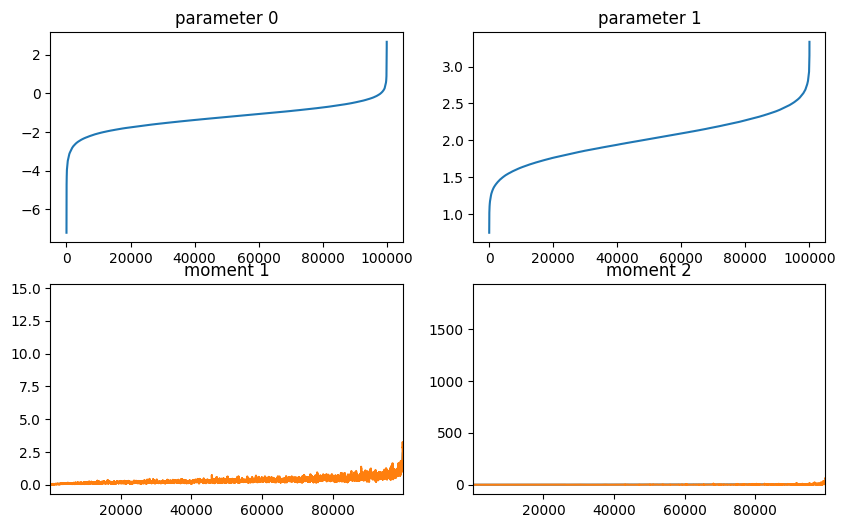

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

# parameters
for j in range(distribution.d):
    axs[j].set_title(f"parameter {j}")
    sort_order = np.argsort(z[j])
    axs[j].plot(z[j][sort_order])

# moments
n_window = 100
for k in [1, 2]:
    axs[k + 1].set_title(f"moment {k}")
    moment = distribution.moment(z, k)
    sort_order = np.argsort(moment)

    moment_empirical = moving_moment(y[sort_order], w=n_window, z=z[:, sort_order], k=k)
    axs[k + 1].plot(moment[sort_order], label="true")
    axs[k + 1].plot(moment_empirical, label="empirical")
    axs[k + 1].set_xlim([n_window, len(y) - n_window])

## Cyclical GLM

In [26]:
glm = CycGLM(dist="normal", eps=eps_glm, max_iter=max_iter, tol=tol)

glm.fit(X_train, y_train)

z_hat["train"]["glm"] = glm.predict(X_train)
z_hat["test"]["glm"] = glm.predict(X_test)

/home/heza7322/PycharmProjects/c-gbm/src/cyc_gbm/distributions.py:289: RuntimeWarning: overflow encountered in exp
  return -np.exp(-2 * z[1]) * (y - z[0]) / (w**2)
/home/heza7322/PycharmProjects/c-gbm/src/cyc_gbm/distributions.py:289: RuntimeWarning: overflow encountered in multiply
  return -np.exp(-2 * z[1]) * (y - z[0]) / (w**2)
/home/heza7322/PycharmProjects/c-gbm/src/cyc_gbm/cyc_glm.py:58: RuntimeWarning: invalid value encountered in matmul
  beta_hat[i, j] = beta_hat[i - 1, j] - self.eps[j] * g @ X
/home/heza7322/PycharmProjects/c-gbm/src/cyc_gbm/distributions.py:291: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-2 * z[1]) * (y - z[0]) ** 2 / (w**2)


### Univariate GBM

In [27]:
# Tune kappa
kappa_uni = tune_kappa(
    X=X_train,
    y=y_train,
    n_splits=n_splits,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    kappa_max=[kappa_max, 0],
    dist=dist,
    random_state=cv_seed,
    verbose=1,
)["kappa"]

gbm_uni = CycGBM(
    kappa=kappa_uni,
    dist="normal",
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_uni.fit(X_train, y_train)

z_hat["train"]["uni-gbm"] = gbm_uni.predict(X_train)
z_hat["test"]["uni-gbm"] = gbm_uni.predict(X_test)

2023-05-10 18:36:27,661 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 10-fold cross-validation
2023-05-10 18:36:27,661 - src.cyc_gbm.utils - INFO - Fold 1/10
2023-05-10 18:36:44,971 - src.cyc_gbm.utils - INFO - Fold 2/10
2023-05-10 18:37:03,496 - src.cyc_gbm.utils - INFO - Fold 3/10
2023-05-10 18:37:19,214 - src.cyc_gbm.utils - INFO - Fold 4/10
2023-05-10 18:37:37,766 - src.cyc_gbm.utils - INFO - Fold 5/10
2023-05-10 18:37:54,455 - src.cyc_gbm.utils - INFO - Fold 6/10
2023-05-10 18:38:09,487 - src.cyc_gbm.utils - INFO - Fold 7/10
2023-05-10 18:38:32,154 - src.cyc_gbm.utils - INFO - Fold 8/10
2023-05-10 18:38:46,298 - src.cyc_gbm.utils - INFO - Fold 9/10
2023-05-10 18:39:02,304 - src.cyc_gbm.utils - INFO - Fold 10/10
2023-05-10 18:39:13,590 - src.cyc_gbm.utils - INFO - Finished tuning of kappa with 10-fold cross-validation


#### Cyclical GBM

In [28]:
kappa_cyc = tune_kappa(
    X=X_train,
    y=y_train,
    n_splits=n_splits,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    kappa_max=kappa_max,
    dist=dist,
    random_state=cv_seed,
    verbose=1,
)["kappa"]

gbm_cyc = CycGBM(
    kappa=kappa_cyc,
    dist="normal",
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_cyc.fit(X_train, y_train)

z_hat["train"]["intercept"] = np.tile(gbm_cyc.z0, (1, len(y_train)))
z_hat["test"]["intercept"] = np.tile(gbm_cyc.z0, (1, len(y_test)))
z_hat["train"]["cyc-gbm"] = gbm_cyc.predict(X_train)
z_hat["test"]["cyc-gbm"] = gbm_cyc.predict(X_test)

2023-05-10 18:39:26,834 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 10-fold cross-validation
2023-05-10 18:39:26,834 - src.cyc_gbm.utils - INFO - Fold 1/10
2023-05-10 18:40:01,289 - src.cyc_gbm.utils - INFO - Fold 2/10
2023-05-10 18:40:41,234 - src.cyc_gbm.utils - INFO - Fold 3/10
2023-05-10 18:41:15,547 - src.cyc_gbm.utils - INFO - Fold 4/10
2023-05-10 18:42:18,341 - src.cyc_gbm.utils - INFO - Fold 5/10
2023-05-10 18:43:23,496 - src.cyc_gbm.utils - INFO - Fold 6/10
2023-05-10 18:44:13,048 - src.cyc_gbm.utils - INFO - Fold 7/10
2023-05-10 18:45:04,439 - src.cyc_gbm.utils - INFO - Fold 8/10
2023-05-10 18:45:48,593 - src.cyc_gbm.utils - INFO - Fold 9/10
2023-05-10 18:46:42,061 - src.cyc_gbm.utils - INFO - Fold 10/10
2023-05-10 18:47:05,207 - src.cyc_gbm.utils - INFO - Finished tuning of kappa with 10-fold cross-validation
/home/heza7322/PycharmProjects/c-gbm/src/cyc_gbm/distributions.py:282: RuntimeWarning: overflow encountered in exp
  + 1 / (2 * w**2) * np.exp(-2 * z[1])

## Results

boosting steps:
         kappa_0  kappa_1
uni-gbm       63        0
cyc-gbm       60       36

losses:
            train    test
intercept   7.103   7.079
glm           NaN     NaN
uni-gbm     7.238   7.218
cyc-gbm    10.818  10.780
true        3.143   3.137


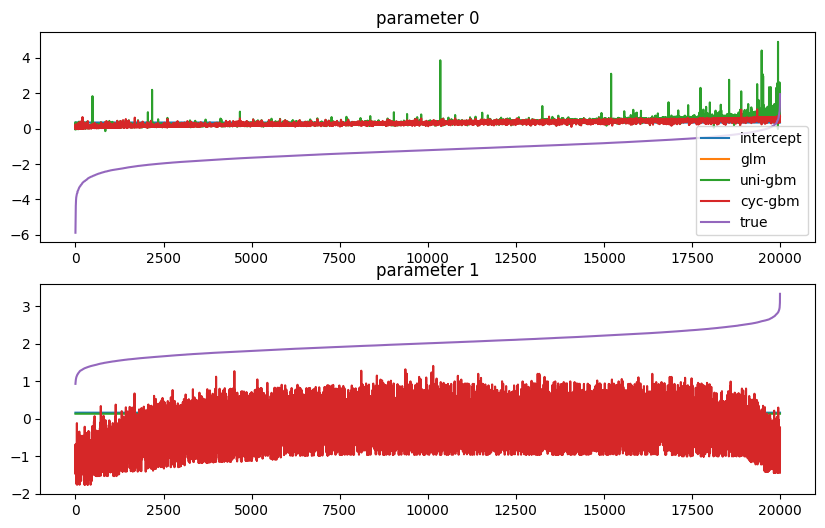

In [29]:
# Tuning results
kappas = pd.DataFrame(
    columns=[f"kappa_{j}" for j in range(0, distribution.d)],
    index=["uni-gbm", "cyc-gbm"],
    dtype=int,
)
kappas.loc["uni-gbm", :] = kappa_uni
kappas.loc["cyc-gbm", :] = kappa_cyc

print("boosting steps:")
print(kappas.astype(int))

# Losses
losses = pd.DataFrame(
    columns=["train", "test"],
    index=z_hat["train"].keys(),
    dtype=float,
)
for data_set, y_set in [("train", y_train), ("test", y_test)]:
    for model in z_hat[data_set].keys():
        losses.loc[model, data_set] = distribution.loss(
            y=y_set, z=z_hat[data_set][model]
        ).mean()
print("\nlosses:")
print(losses.round(3))

# Plot parameter estimates
fig, axs = plt.subplots(distribution.d, 1, figsize=(10, int(3 * distribution.d)))
axs = axs.flatten()

for j in range(distribution.d):
    axs[j].set_title(f"parameter {j}")
    sort_order = np.argsort(z_hat["test"]["true"][j])
    for model in z_hat["train"].keys():
        axs[j].plot(z_hat["test"][model][j][sort_order], label=model)

axs[0].legend();
